In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-sales-data/car_prices.csv


In [15]:
# Vehicle Price Prediction - Model Training
# AI Term Project - XGBoost Implementation

# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
XGBoost version: 2.0.3


In [16]:
# ============================================================================
# PART 2: DATA LOADING
# ============================================================================

# Load the dataset
df = pd.read_csv('/kaggle/input/vehicle-sales-data/car_prices.csv')

print("\n" + "="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())


DATASET OVERVIEW
Dataset shape: (558837, 16)

First few rows:
   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  i

In [17]:
# ============================================================================
# PART 3: OUTLIER DETECTION AND FILTERING
# ============================================================================

print("\n" + "="*70)
print("OUTLIER FILTERING")
print("="*70)

# Store original size
original_size = len(df)

# Filter outliers based on domain knowledge
df_filtered = df[
    (df['year'] >= 1990) &
    (df['year'] <= 2026) &
    (df['odometer'] > 0) &
    (df['odometer'] <= 500000) &
    (df['sellingprice'] > 500) &
    (df['sellingprice'] <= 150000) &
    (df['condition'] >= 1) &
    (df['condition'] <= 49)
].copy()

# Additional statistical outlier removal using IQR for sellingprice
Q1 = df_filtered['sellingprice'].quantile(0.01)
Q3 = df_filtered['sellingprice'].quantile(0.99)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_filtered[
    (df_filtered['sellingprice'] >= lower_bound) &
    (df_filtered['sellingprice'] <= upper_bound)
]

print(f"Original dataset: {original_size:,} rows")
print(f"After filtering: {len(df_filtered):,} rows")
print(f"Removed: {original_size - len(df_filtered):,} rows ({100*(original_size - len(df_filtered))/original_size:.2f}%)")


OUTLIER FILTERING
Original dataset: 558,837 rows
After filtering: 540,161 rows
Removed: 18,676 rows (3.34%)


In [18]:
# ============================================================================
# PART 4: STRATIFIED SAMPLING
# ============================================================================

print("\n" + "="*70)
print("STRATIFIED SAMPLING")
print("="*70)

# Target sample size (10-20% of filtered data)
target_size = min(100000, int(len(df_filtered) * 0.2))

# Create stratification bins
df_filtered['year_bin'] = pd.cut(df_filtered['year'], bins=10, labels=False)
df_filtered['price_bin'] = pd.qcut(df_filtered['sellingprice'], q=10, labels=False, duplicates='drop')

# Perform stratified sampling
df_sample = df_filtered.groupby(['year_bin', 'price_bin'], group_keys=False).apply(
    lambda x: x.sample(min(len(x), max(1, int(len(x) * target_size / len(df_filtered)))), random_state=RANDOM_STATE)
).reset_index(drop=True)

# Remove temporary binning columns
df_sample = df_sample.drop(['year_bin', 'price_bin'], axis=1)

print(f"Target sample size: {target_size:,}")
print(f"Actual sample size: {len(df_sample):,}")
print(f"Sampling ratio: {100*len(df_sample)/len(df_filtered):.2f}%")

# Verify distribution preservation
print("\nYear distribution comparison:")
print("Original:")
print(df_filtered['year'].value_counts(bins=5, sort=False).head())
print("\nSampled:")
print(df_sample['year'].value_counts(bins=5, sort=False).head())


STRATIFIED SAMPLING
Target sample size: 100,000
Actual sample size: 99,970
Sampling ratio: 18.51%

Year distribution comparison:
Original:
(1989.974, 1995.0]       690
(1995.0, 2000.0]        9158
(2000.0, 2005.0]       60930
(2005.0, 2010.0]      131733
(2010.0, 2015.0]      337650
Name: count, dtype: int64

Sampled:
(1989.974, 1995.0]      129
(1995.0, 2000.0]       1693
(2000.0, 2005.0]      11270
(2005.0, 2010.0]      24379
(2010.0, 2015.0]      62499
Name: count, dtype: int64


In [19]:
# ============================================================================
# PART 5: DATA CLEANING AND STANDARDIZATION
# ============================================================================

print("\n" + "="*70)
print("DATA CLEANING AND STANDARDIZATION")
print("="*70)

# 1. Handle missing values first
df_sample['make'] = df_sample['make'].fillna('Unknown')
df_sample['model'] = df_sample['model'].fillna('Unknown')
df_sample['body'] = df_sample['body'].fillna('Unknown')
df_sample['transmission'] = df_sample['transmission'].fillna('unknown')

# 2. Standardize make (brand) - convert to title case
df_sample['make'] = df_sample['make'].astype(str).str.strip().str.title()
print(f"Unique makes after cleaning: {df_sample['make'].nunique()}")

# 3. Standardize model - convert to title case and strip whitespace
df_sample['model'] = df_sample['model'].astype(str).str.strip().str.title()
print(f"Unique models after cleaning: {df_sample['model'].nunique()}")

# 4. Standardize and classify body types
def standardize_body_type(body):
    """Standardize body type classifications"""
    if pd.isna(body):
        return 'Other'
    
    body = str(body).lower().strip()
    
    # Coupe variations
    if 'coupe' in body or 'cpe' in body:
        return 'Coupe'
    
    # Sedan variations
    if 'sedan' in body or 'sdn' in body:
        return 'Sedan'
    
    # SUV variations
    if 'suv' in body or 'sport utility' in body:
        return 'SUV'
    
    # Truck variations
    if 'truck' in body or 'pickup' in body:
        return 'Truck'
    
    # Van variations
    if 'van' in body or 'minivan' in body:
        return 'Van'
    
    # Wagon variations
    if 'wagon' in body or 'wgn' in body:
        return 'Wagon'
    
    # Convertible variations
    if 'convertible' in body or 'conv' in body or 'cabriolet' in body:
        return 'Convertible'
    
    # Hatchback variations
    if 'hatchback' in body or 'hatch' in body:
        return 'Hatchback'
    
    # Default
    return 'Other'

df_sample['body'] = df_sample['body'].apply(standardize_body_type)
print(f"\nBody types after standardization:")
print(df_sample['body'].value_counts())

# 5. Standardize transmission
df_sample['transmission'] = df_sample['transmission'].astype(str).str.strip().str.lower()

print(f"\nMissing values after cleaning:")
print(df_sample.isnull().sum())

print(f"\nData cleaning summary:")
print(f"  - Makes standardized: {df_sample['make'].nunique()} unique brands")
print(f"  - Models standardized: {df_sample['model'].nunique()} unique models")
print(f"  - Body types reduced to standard categories")
print(f"  - Transmission values normalized")


DATA CLEANING AND STANDARDIZATION
Unique makes after cleaning: 55
Unique models after cleaning: 706

Body types after standardization:
body
Sedan          44532
SUV            25717
Other          10814
Van             5762
Hatchback       4713
Coupe           3517
Wagon           2916
Convertible     1999
Name: count, dtype: int64

Missing values after cleaning:
year               0
make               0
model              0
trim            1779
body               0
transmission       0
vin                0
state              0
condition          0
odometer           0
color            125
interior         125
seller             0
mmr                0
sellingprice       0
saledate           0
dtype: int64

Data cleaning summary:
  - Makes standardized: 55 unique brands
  - Models standardized: 706 unique models
  - Body types reduced to standard categories
  - Transmission values normalized


In [20]:
# ============================================================================
# PART 6: ENCODING CATEGORICAL VARIABLES
# ============================================================================

print("\n" + "="*70)
print("ENCODING CATEGORICAL VARIABLES")
print("="*70)

# Create label encoders for categorical variables
categorical_cols = ['make', 'model', 'body', 'transmission']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_sample[f'{col}_encoded'] = le.fit_transform(df_sample[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")


ENCODING CATEGORICAL VARIABLES
make: 55 unique values
model: 706 unique values
body: 8 unique values
transmission: 3 unique values


In [21]:
# ============================================================================
# PART 7: PREPARE FEATURES AND TARGET
# ============================================================================

print("\n" + "="*70)
print("PREPARING FEATURES AND TARGET")
print("="*70)

# Select features for the model (excluding mmr)
feature_cols = [
    'year', 'condition', 'odometer',
    'make_encoded', 'model_encoded', 'body_encoded', 'transmission_encoded'
]

X = df_sample[feature_cols]
y = df_sample['sellingprice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")


PREPARING FEATURES AND TARGET
Features shape: (99970, 7)
Target shape: (99970,)

Features used:
  1. year
  2. condition
  3. odometer
  4. make_encoded
  5. model_encoded
  6. body_encoded
  7. transmission_encoded


In [22]:
# ============================================================================
# PART 8: TRAIN-TEST SPLIT
# ============================================================================

print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Split ratio: 80/20")


TRAIN-TEST SPLIT
Training set: 79,976 samples
Test set: 19,994 samples
Split ratio: 80/20


In [23]:
# ============================================================================
# PART 9: MODEL TRAINING - XGBOOST
# ============================================================================

print("\n" + "="*70)
print("XGBOOST MODEL TRAINING")
print("="*70)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

print("Model parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Train the model
print("\nTraining XGBoost model...")
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train, verbose=False)
print("Training completed!")


XGBOOST MODEL TRAINING
Model parameters:
  objective: reg:squarederror
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 200
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  eval_metric: rmse

Training XGBoost model...
Training completed!


In [24]:
# ============================================================================
# PART 10: MODEL EVALUATION
# ============================================================================

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\nPERFORMANCE METRICS:")
print("-" * 50)
print(f"{'Metric':<20} {'Training':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R² Score':<20} {train_r2:<15.4f} {test_r2:<15.4f}")
print(f"{'MAE ($)':<20} {train_mae:<15.2f} {test_mae:<15.2f}")
print(f"{'RMSE ($)':<20} {train_rmse:<15.2f} {test_rmse:<15.2f}")
print(f"{'MAPE (%)':<20} {train_mape:<15.2f} {test_mape:<15.2f}")
print("-" * 50)

# Cross-validation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


MODEL EVALUATION

PERFORMANCE METRICS:
--------------------------------------------------
Metric               Training        Test           
--------------------------------------------------
R² Score             0.9044          0.8928         
MAE ($)              1865.20         1952.31        
RMSE ($)             2953.20         3085.00        
MAPE (%)             19.70           20.16          
--------------------------------------------------

Performing 5-fold cross-validation...
CV R² scores: [0.88782818 0.89105679 0.88614266 0.88251455 0.88663801]
Mean CV R²: 0.8868 (+/- 0.0055)



FEATURE IMPORTANCE ANALYSIS

Feature Importance Ranking:
----------------------------------------
year                      0.2488
body_encoded              0.2061
odometer                  0.1948
make_encoded              0.1559
model_encoded             0.0995
condition                 0.0843
transmission_encoded      0.0105

Feature importance plot saved as 'feature_importance.png'


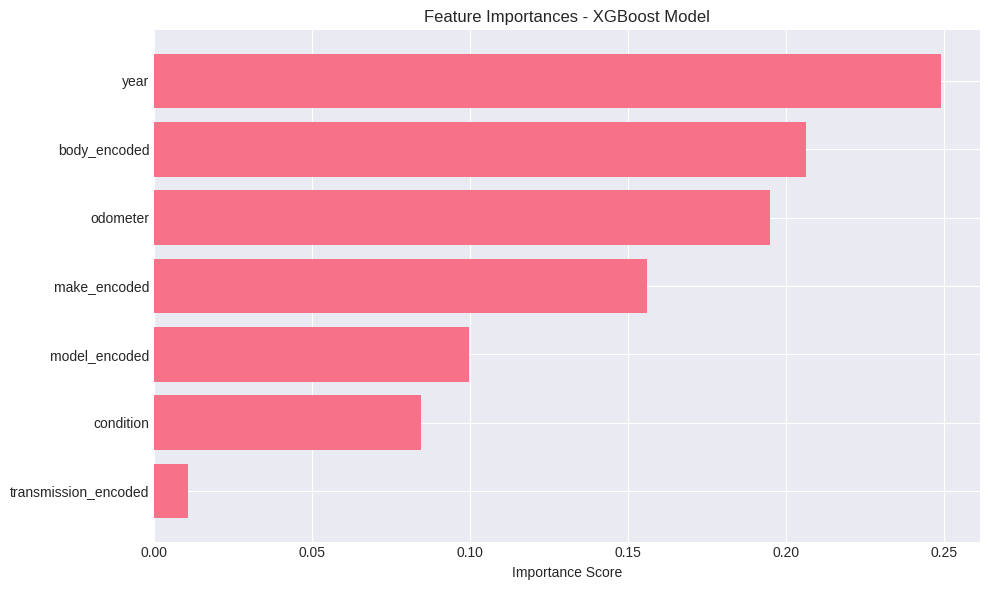

In [25]:
# ============================================================================
# PART 11: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print("-" * 40)
for idx, row in importance_df.iterrows():
    print(f"{row['feature']:<25} {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved as 'feature_importance.png'")
plt.show()

In [26]:
# ============================================================================
# PART 12: SAVE MODEL AND ENCODERS
# ============================================================================

print("\n" + "="*70)
print("SAVING MODEL AND ENCODERS")
print("="*70)

# Save the model
joblib.dump(model, 'vehicle_price_model.pkl')
print("Model saved as 'vehicle_price_model.pkl'")

# Save label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Label encoders saved as 'label_encoders.pkl'")

# Save feature columns
joblib.dump(feature_cols, 'feature_columns.pkl')
print("Feature columns saved as 'feature_columns.pkl'")

# Save make-model mapping for UI dropdown
# Handle any NaN values in model column before creating mapping
make_model_mapping = {}
for make in df_sample['make'].unique():
    models = df_sample[df_sample['make'] == make]['model'].dropna().unique()
    # Convert to string and sort
    models = sorted([str(m) for m in models])
    if models:  # Only add if there are models
        make_model_mapping[make] = models

joblib.dump(make_model_mapping, 'make_model_mapping.pkl')
print("Make-model mapping saved as 'make_model_mapping.pkl'")

# Save sample statistics for later use
statistics = {
    'train_size': len(X_train),
    'test_size': len(X_test),
    'r2_score': test_r2,
    'mae': test_mae,
    'rmse': test_rmse,
    'mape': test_mape,
    'feature_importance': importance_df.to_dict()
}
joblib.dump(statistics, 'model_statistics.pkl')
print("Model statistics saved as 'model_statistics.pkl'")


SAVING MODEL AND ENCODERS
Model saved as 'vehicle_price_model.pkl'
Label encoders saved as 'label_encoders.pkl'
Feature columns saved as 'feature_columns.pkl'
Make-model mapping saved as 'make_model_mapping.pkl'
Model statistics saved as 'model_statistics.pkl'


In [27]:
# ============================================================================
# PART 13: EXAMPLE PREDICTIONS
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE PREDICTIONS")
print("="*70)

# Create example predictions
examples = [
    {'year': 2015, 'make': 'Ford', 'model': 'F-150', 'body': 'Truck', 
     'transmission': 'automatic', 'condition': 35, 'odometer': 50000},
    {'year': 2020, 'make': 'Toyota', 'model': 'Camry', 'body': 'Sedan',
     'transmission': 'automatic', 'condition': 40, 'odometer': 25000},
    {'year': 2010, 'make': 'Honda', 'model': 'Civic', 'body': 'Sedan',
     'transmission': 'automatic', 'condition': 25, 'odometer': 120000}
]

print("\nSample predictions:")
print("-" * 70)
for i, ex in enumerate(examples, 1):
    # Prepare features
    ex_df = pd.DataFrame([ex])
    
    # Encode categoricals
    for col in categorical_cols:
        if ex[col] in label_encoders[col].classes_:
            ex_df[f'{col}_encoded'] = label_encoders[col].transform([ex[col]])[0]
        else:
            ex_df[f'{col}_encoded'] = 0
    
    # Make prediction
    pred = model.predict(ex_df[feature_cols])[0]
    
    print(f"\nExample {i}:")
    print(f"  {ex['year']} {ex['make']} {ex['model']}")
    print(f"  Odometer: {ex['odometer']:,} miles | Condition: {ex['condition']}")
    print(f"  Predicted Price: ${pred:,.2f}")

print("\n" + "="*70)
print("MODEL TRAINING COMPLETE!")
print("="*70)
print("\nFiles created:")
print("  - vehicle_price_model.pkl")
print("  - label_encoders.pkl")
print("  - feature_columns.pkl")
print("  - model_statistics.pkl")
print("  - make_model_mapping.pkl (for UI dropdowns)")
print("  - feature_importance.png")
print("\nYou can now use these files in your Streamlit application!")


EXAMPLE PREDICTIONS

Sample predictions:
----------------------------------------------------------------------

Example 1:
  2015 Ford F-150
  Odometer: 50,000 miles | Condition: 35
  Predicted Price: $29,971.81

Example 2:
  2020 Toyota Camry
  Odometer: 25,000 miles | Condition: 40
  Predicted Price: $15,559.36

Example 3:
  2010 Honda Civic
  Odometer: 120,000 miles | Condition: 25
  Predicted Price: $6,188.48

MODEL TRAINING COMPLETE!

Files created:
  - vehicle_price_model.pkl
  - label_encoders.pkl
  - feature_columns.pkl
  - model_statistics.pkl
  - make_model_mapping.pkl (for UI dropdowns)
  - feature_importance.png

You can now use these files in your Streamlit application!
